<h1 align="center">Machine Learning and Vision Lab</h1>
<h4 align="center">Dr. Mohammadzadeh</h4>
<h4 align="center">Sharif University of Technology, Fall 2023</h4>
<h4 align="center">Amir Hossein Yari - 99102507</h4>
<h4 align="center">Lab 4 - SVM Classification</h4>

In [10]:
# Import required package
import os
import random
import cv2
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [11]:
# Function to load images from a folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

# Load images from the "happy" and "surprise" and "disgust" and "neutral" folders
happy_images = load_images_from_folder("happy")
surprise_images = load_images_from_folder("surprise")
disgust_images = load_images_from_folder("disgust")
neutral_images = load_images_from_folder("neutral")

In [12]:
# Shuffle the images to randomize the selection
random.shuffle(happy_images)
random.shuffle(surprise_images)
random.shuffle(disgust_images)
random.shuffle(neutral_images)

# Select desired number of images for training from each category
happy_train_images = happy_images[:60]
surprise_train_images = surprise_images[:60]
disgust_train_images = disgust_images[:30]
neutral_train_images = neutral_images[:120]

# Use the remaining images as the test set
happy_test_images = happy_images[60:]
surprise_test_images = surprise_images[60:]
disgust_test_images = disgust_images[30:]
neutral_test_images = neutral_images[120:]

# Combine the train and test sets
train_images = happy_train_images + surprise_train_images + neutral_train_images
test_images = happy_test_images + surprise_test_images + neutral_test_images

# Convert the images to grayscale and flatten them
train_data = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).flatten() for img in train_images]
test_data = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).flatten() for img in test_images]

# Normalized data
scaler = StandardScaler()
scaler = scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [13]:
# Perform PCA to reduce the dimension to 70
n_components = 50
pca = PCA(n_components=n_components)

# Fit and transform the PCA on the training data
train_pca = pca.fit_transform(train_data)

# Transform the test data using the same PCA
test_pca = pca.transform(test_data)

# Define the class labels for the training data
class_labels_train = [0] * len(happy_train_images) + [1] * len(surprise_train_images) + [3] * len(neutral_train_images) # 0 for "happy," 1 for "surprise", 3 for "neutral"

# Define the class labels for the training data
class_labels_test = [0] * len(happy_test_images) + [1] * len(surprise_test_images) + [3] * len(neutral_test_images)# 0 for "happy," 1 for "surprise", 3 for "neutral"

In [14]:
svm_classifier = svm.SVC(kernel='linear', C=1)

# Fit the classifier to the training data
svm_classifier.fit(train_pca, class_labels_train)

# Make predictions on the test data
y_pred = svm_classifier.predict(test_pca)

# Calculate and display the confusion matrix
conf_matrix = confusion_matrix(class_labels_test, y_pred)

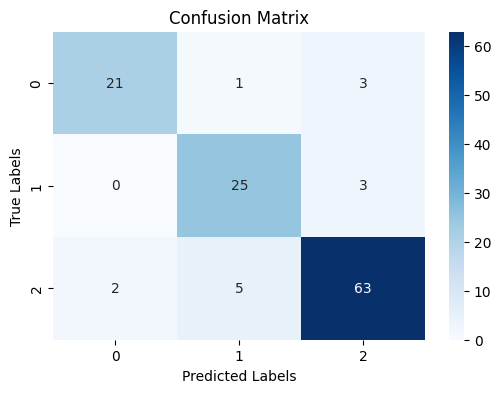

In [15]:
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [16]:
for i in range(3):
    TP = conf_matrix[i, i]
    FN = sum(conf_matrix[i, :]) - TP
    FP = sum(conf_matrix[:, i]) - TP
    TN = np.sum(conf_matrix) - (TP + FP + FN)

    # Calculate Recall for class i
    recall = TP / (TP + FN)
    
    # Calculate Precision for class i
    precision = TP / (TP + FP)
    
    # Calculate Accuracy for class i
    accuracy = (TP + TN) / (TP + TN + FP + FN)

    print(f"Class {i + 1} - Recall: {recall:.2f}, Precision: {precision:.2f}, Accuracy: {accuracy:.2f}")


Class 1 - Recall: 0.84, Precision: 0.91, Accuracy: 0.95
Class 2 - Recall: 0.89, Precision: 0.81, Accuracy: 0.93
Class 3 - Recall: 0.90, Precision: 0.91, Accuracy: 0.89


In [17]:
def k_fold_cross_validation(X, y, classifier, k):
    n = len(X)
    fold_size = n // k
    accuracies = []

    for i in range(k):
        # Split the data into training and testing sets for the current fold
        test_indices = list(range(i * fold_size, (i + 1) * fold_size))
        train_indices = [j for j in range(n) if j not in test_indices]

        X_train, X_val= X[train_indices], X[test_indices]
        y_train, y_val = y[train_indices], y[test_indices]

        # Train the classifier on the training data
        classifier.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = classifier.predict(X_val)

        # Calculate accuracy for this fold
        accuracy = np.mean(y_pred == y_val)
        accuracies.append(accuracy)

    return accuracies

In [29]:
# Define a list of candidate C values to be tested
C_values = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

# Perform k-fold cross-validation for each C value
best_accuracy = 0
best_C = None

for C in C_values:
    svm_classifier = svm.SVC(kernel='linear', C=C)
    accuracies = k_fold_cross_validation(train_pca, np.array(class_labels_train), svm_classifier, 5)
    
    # Calculate and record the average accuracy for each C value
    average_accuracy = np.mean(accuracies)
    print("average accuracy = " + str(average_accuracy))
    
    # Check if this C value has the highest average accuracy
    if average_accuracy > best_accuracy:
        best_accuracy = average_accuracy
        best_C = C

# Choose the C value that yields the best performance
print(f"Best C value: {best_C}")

average accuracy = 0.6708333333333334
average accuracy = 0.7791666666666666
average accuracy = 0.8166666666666668
average accuracy = 0.8041666666666666
average accuracy = 0.8041666666666666
Best C value: 0.001


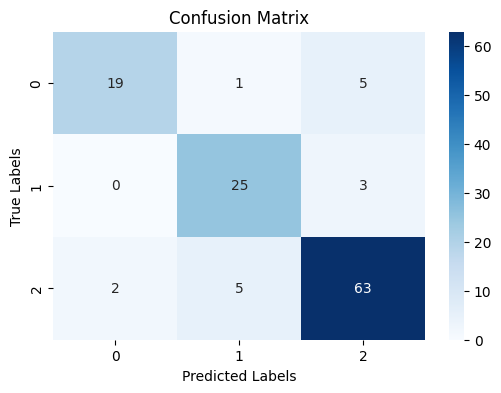

In [24]:
svm_classifier = svm.SVC(kernel='linear', C=0.001)

# Fit the classifier to the training data
svm_classifier.fit(train_pca, class_labels_train)

# Make predictions on the test data
y_pred = svm_classifier.predict(test_pca)

# Calculate and display the confusion matrix
conf_matrix_best = confusion_matrix(class_labels_test, y_pred)

# plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_best, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

Best C: 10
Best Gamma: 1e-06


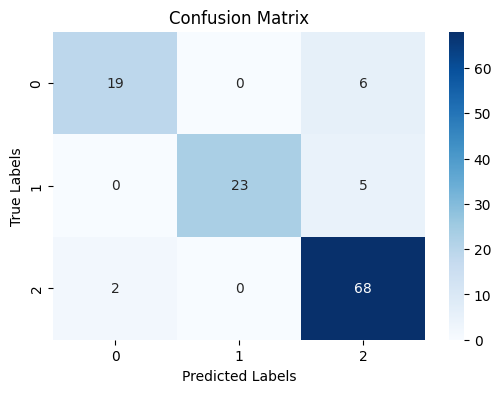

In [25]:
# Create an SVM classifier with an RBF kernel
svm_classifier = svm.SVC(kernel='rbf')

# Define a parameter grid to search for the best hyperparameters
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [1e-4, 1e-5, 1e-6]
}

# Create a GridSearchCV object with the SVM classifier and parameter grid
grid_search = GridSearchCV(svm_classifier, param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV to the training data
grid_search.fit(train_pca, class_labels_train)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_
best_C = best_params['C']
best_gamma = best_params['gamma']

# Train an SVM classifier with the best hyperparameters on the full training set
best_svm_classifier = svm.SVC(kernel='rbf', C=best_C, gamma=best_gamma)
best_svm_classifier.fit(train_pca, class_labels_train)

# Make predictions on the test data
y_pred = best_svm_classifier.predict(test_pca)

# Calculate the confusion matrix
confusion = confusion_matrix(class_labels_test, y_pred)

print("Best C:", best_C)
print("Best Gamma:", best_gamma)

# plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [26]:
for i in range(3):
    TP = confusion[i, i]
    FN = sum(confusion[i, :]) - TP
    FP = sum(confusion[:, i]) - TP
    TN = np.sum(confusion) - (TP + FP + FN)

    # Calculate Recall for class i
    recall = TP / (TP + FN)
    
    # Calculate Precision for class i
    precision = TP / (TP + FP)
    
    # Calculate Accuracy for class i
    accuracy = (TP + TN) / (TP + TN + FP + FN)

    print(f"Class {i + 1} - Recall: {recall:.2f}, Precision: {precision:.2f}, Accuracy: {accuracy:.2f}")


Class 1 - Recall: 0.76, Precision: 0.90, Accuracy: 0.93
Class 2 - Recall: 0.82, Precision: 1.00, Accuracy: 0.96
Class 3 - Recall: 0.97, Precision: 0.86, Accuracy: 0.89
